In [44]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
import torch as th
from data_preprocessing.ImageDataset import CustomImageDataset
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import trange
from concurrent.futures import ThreadPoolExecutor
import random

In [34]:
dataset_path = Path("../data/datasets/dataset_2000_200_5.pth")

if not dataset_path.exists():
    print("path does not exist")

dataset = th.load(dataset_path)

In [35]:
th_dataset = CustomImageDataset(dataset)
train_loader = DataLoader(th_dataset, batch_size=32, shuffle=True)

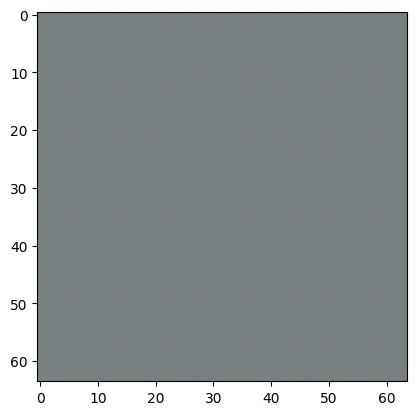

In [37]:
class InpaintingAutoencoder(nn.Module):
    def __init__(self, in_channels=3, middle_channels= [64, 128, 256], kernel_size = [3, 3, 3], stride = [2, 2, 2], padding = [1, 1, 1], output_padding = [1, 1, 1]):
        super(InpaintingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels[0], kernel_size=kernel_size[0], stride=stride[0], padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(middle_channels[0], middle_channels[1], kernel_size=kernel_size[1], stride=stride[1], padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(middle_channels[1], middle_channels[2], kernel_size=kernel_size[2], stride=stride[2], padding=1),  # 16x16 -> 8x8
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(middle_channels[2], middle_channels[1], kernel_size=kernel_size[2], stride=stride[2], padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(middle_channels[1], middle_channels[0], kernel_size=kernel_size[1], stride=stride[1], padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(middle_channels[0], in_channels, kernel_size=kernel_size[0], stride=stride[0], padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = InpaintingAutoencoder()

new_image = model.forward(dataset["images"][0])
new_image_np = new_image.detach().numpy()
plt.imshow(new_image_np.transpose(1, 2, 0))

In [38]:
def image_loss(output: th.tensor, target: th.tensor, mask: th.tensor):
    return th.mean((output - target) ** 2 * mask)

def calculate_batch_loss(output: th.tensor, target: th.tensor, mask: th.tensor):
    loss = 0
    for i in range(output.shape[0]):
        loss += th.mean((output[i] - target[i]) ** 2 * mask[i])
        
    return loss / output.shape[0]

In [39]:
model = InpaintingAutoencoder()

optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 3

initial_weights = model.state_dict()

epoch_losses = []
for epoch in trange(n_epochs):
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        img, _, mask, _ = batch
        output = model(img)
        
        loss = calculate_batch_loss(output, img, mask)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    epoch_losses.append(total_loss / len(train_loader))

model.eval()
final_weights = model.state_dict()

100%|██████████| 3/3 [00:50<00:00, 16.94s/it]


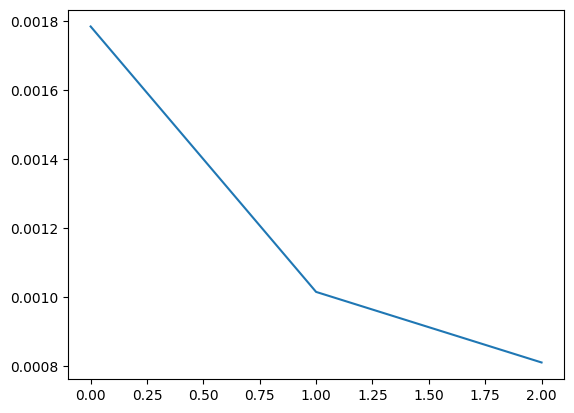

In [40]:
plt.plot(epoch_losses)

In [41]:
all(th.equal(initial_weights[key], final_weights[key]) for key in initial_weights.keys())

True

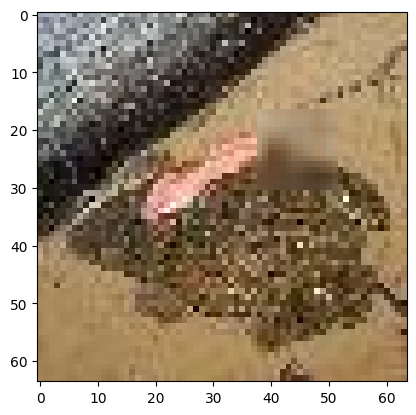

In [62]:
sample_idx = random.randint(0, len(dataset["images"]))

sample_img = dataset["images"][sample_idx]

predicted_img = model(sample_img).detach().numpy()

mask = dataset["masks"][sample_idx]

inpainted_img = sample_img * (1 - mask) + predicted_img * mask

plt.imshow(inpainted_img.detach().numpy().transpose(1, 2, 0))
plt.show()